# What TOC rules have had the biggest impact?

We would like to evaluate which Transit Oriented Communities rules have had the biggest impact,
and which transit lines have seen the most development.

We will proceed by reconstructing a TOC map,
and try to assign developments to specific transit lines.

In [1]:
import datetime
import functools

import contextily
import intake
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas
import geopandas

import toc

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")
city_boundary = catalog.city_boundary.read()

We will err on the side of finding ineligible lines, since headways and stops can change.
In order to do that, we will have a headway cutoff greater than the TOC cutoff of 15 minutes,
and buffer the tiers an additional 20%.

In [3]:
cutoff = 18.0
cushion = 1.2

## TOC Tiers from bus service

Let's read some GTFS feeds to get representative weekday peak frequencies for
Metro Bus, Santa Monica Big Blue Bus, and Culver City Bus:

In [4]:
# Current Metro GTFS
# METRO_BUS_GTFS_URL = "https://gitlab.com/LACMTA/gtfs_bus/-/raw/master/gtfs_bus.zip?inline=false"

# Metro GTFS from December 2017
METRO_BUS_GTFS_URL = "https://gitlab.com/LACMTA/gtfs_bus/-/raw/aef844c79c31c40ef751a3472b3882406307b05a/gtfs_bus.zip?inline=false"

# Current Big Blue Bus GTFS
BBB_GTFS_URL = "http://gtfs.bigbluebus.com/current.zip"

# Current 
CC_GTFS_URL = "https://www.culvercity.org/home/showdocument?id=18585"

# A cutoff headway, in minutes, for determining TOC eligible bus lines.
# This is highter than the TOC value of 15 minutes, but we want to err
# on the side of catching edge cases, or cases where the frequency has
# changed since the TOC entitlement.

test_date = datetime.date(2018, 2, 8)

# Load TOC lines for Metro, Big Blue Bus, and Culver City Bus
metro_bus_toc_lines = toc.toc_bus_lines(
    METRO_BUS_GTFS_URL,
    cutoff=cutoff,
    test_date=test_date,
)
bbb_toc_lines = toc.toc_bus_lines(BBB_GTFS_URL, cutoff=cutoff)
cc_toc_lines = toc.toc_bus_lines(CC_GTFS_URL, cutoff=cutoff)

# Combine into one.
toc_bus_lines = pandas.concat(
    [metro_bus_toc_lines, bbb_toc_lines, cc_toc_lines],
    axis=0,
    sort=False
)

We now find where the TOC eligible bus lines intersect,
and compute tier geometries for those intersections.

In [5]:
toc_bus_intersections = toc.bus_intersections(toc_bus_lines)
toc_bus_intersection_tiers = toc.compute_toc_tiers_from_bus_intersections(
    toc_bus_intersections,
    city_boundary,
    cushion=cushion,
)

Let's create a plot of the TOC tiers due to bus intersections:

In [6]:
colors = ["#f1eef6", "#bdc9e1", "#74a9cf", "#0570b0"]
def plot_toc_tiers(gdf):
    fig, ax = plt.subplots(figsize=(16,16))
    WEB_MERCATOR = 3857
    city_boundary.to_crs(epsg=WEB_MERCATOR).plot(ax=ax, alpha=0.1, color="gray")
    for color, tier in zip(colors, range(1,5)):
        colname = f"tier_{tier}"
        t = gdf.set_geometry(colname)
        if not t[colname].is_empty.all():
            t.to_crs(epsg=WEB_MERCATOR).plot(ax=ax, color=color)
    contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
    return fig

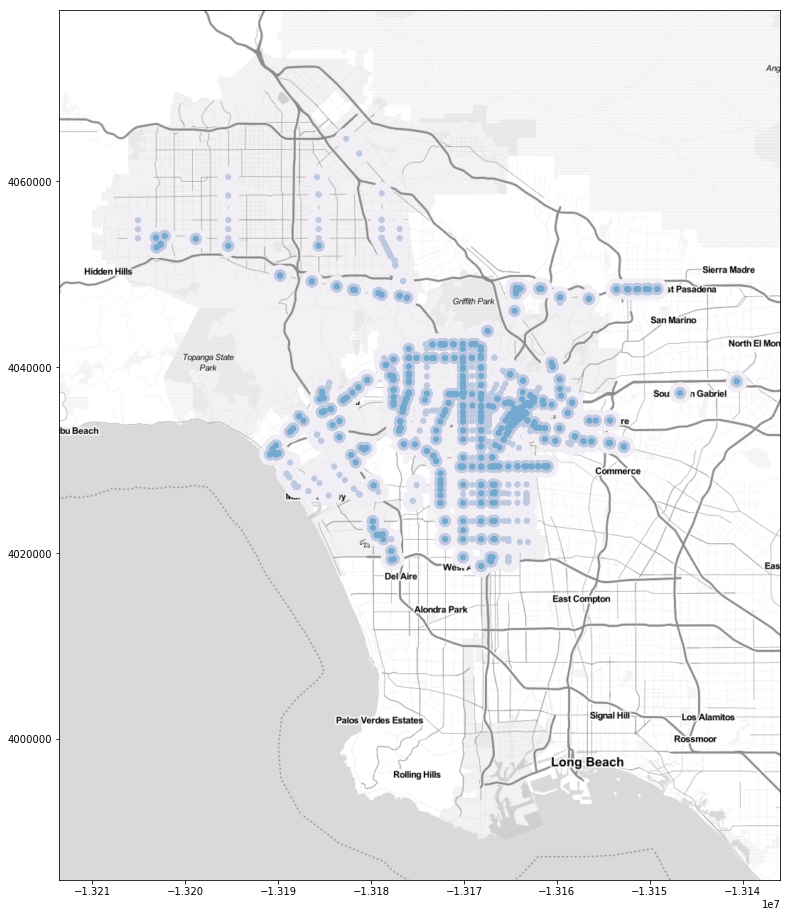

In [7]:
fig = plot_toc_tiers(toc_bus_intersection_tiers)
fig.show()

# TOC Tiers from Metrolink service

Metrolink stations (few though they may be) also generate TOC zones.
Here we create TOC tiers from the those:

In [8]:
metrolink_stations = catalog.metrolink_stations.read()
toc_metrolink_tiers = toc.compute_toc_tiers_from_metrolink_stations(
    metrolink_stations,
    city_boundary,
    cushion=cushion,
)

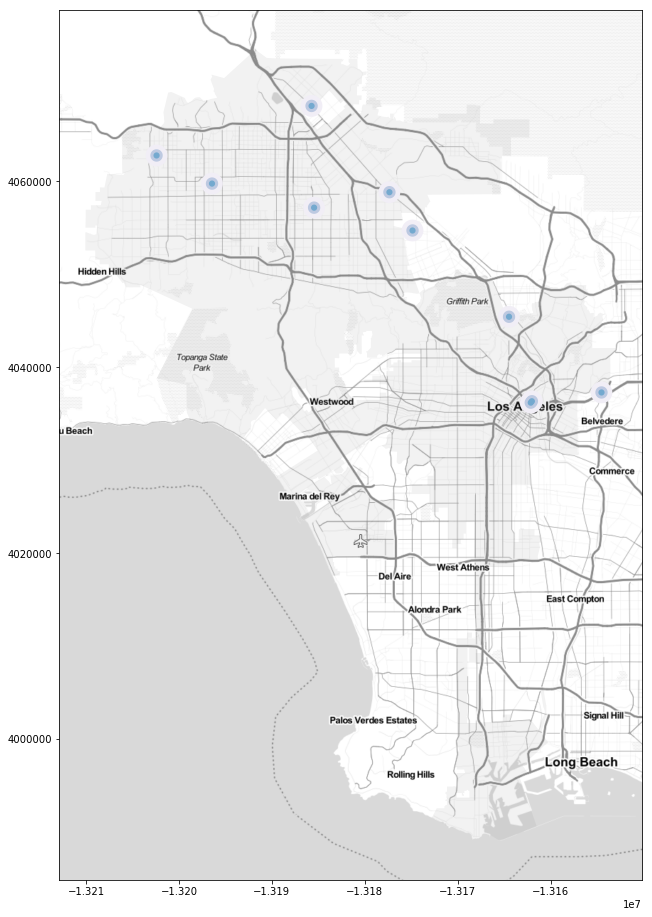

In [9]:
fig = plot_toc_tiers(toc_metrolink_tiers)
fig.show()

## TOC Tiers from Metro rail service

The most impactful TOC zones are from Metro rail stations.
Planned stations are included in TOC considerations, so we also
bring in data for the Crenshaw Line, the Purple Line, and the Regional Connector:

In [10]:
metro_rail_stations = catalog.metro_rail_stations.read()
# Read Crenshaw, Purple Line, and Regional Connector data from LA Times datadesk,
# who produced GeoJSON from Metro planning documents. I was not able to find
# the data elsewhere.
crenshaw = geopandas.read_file(
    "https://raw.githubusercontent.com/datadesk/lametro-maps/master/planned-crenshaw-stops.geojson"
).rename(
    columns={"station": "STATION", "line": "LINE"}
).assign(LINENUM2=None, LINENUM=-1)
purple = geopandas.read_file(
    "https://raw.githubusercontent.com/datadesk/lametro-maps/master/planned-purple-line-extension-stops.geojson"
).rename(
    columns={"name": "STATION"}
).assign(LINENUM2=None, LINENUM=805, LINE="Purple").drop(
    columns=["marker-color", "marker-size", "marker-symbol"]
)
regional_connector = geopandas.read_file(
    "https://github.com/datadesk/lametro-maps/raw/master/planned-regional-connector-stops.json"
).assign(LINENUM2=None, LINENUM=801, LINE="Regional Connector")

toc_metro_rail_tiers = toc.compute_toc_tiers_from_metro_rail(
    metro_rail_stations.append(crenshaw, sort=False)
    .append(purple, sort=False)
    .append(regional_connector, sort=False),
    toc_bus_lines,
    city_boundary,
    cushion=cushion,
)

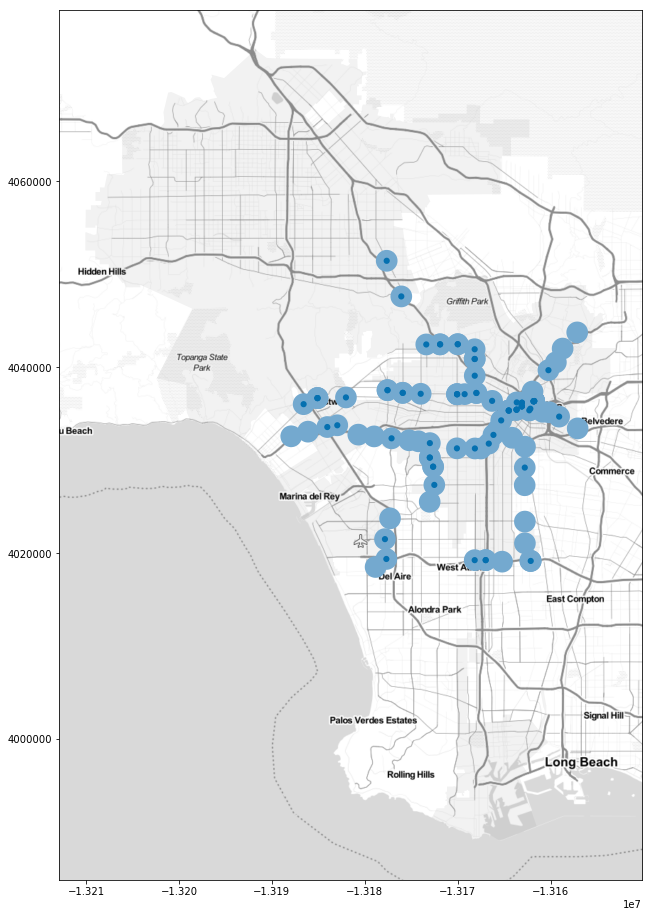

In [11]:
fig = plot_toc_tiers(toc_metro_rail_tiers)
fig.show()

## Full TOC tiers

All of the TOC tiers from above may be combined into a single TOC map:

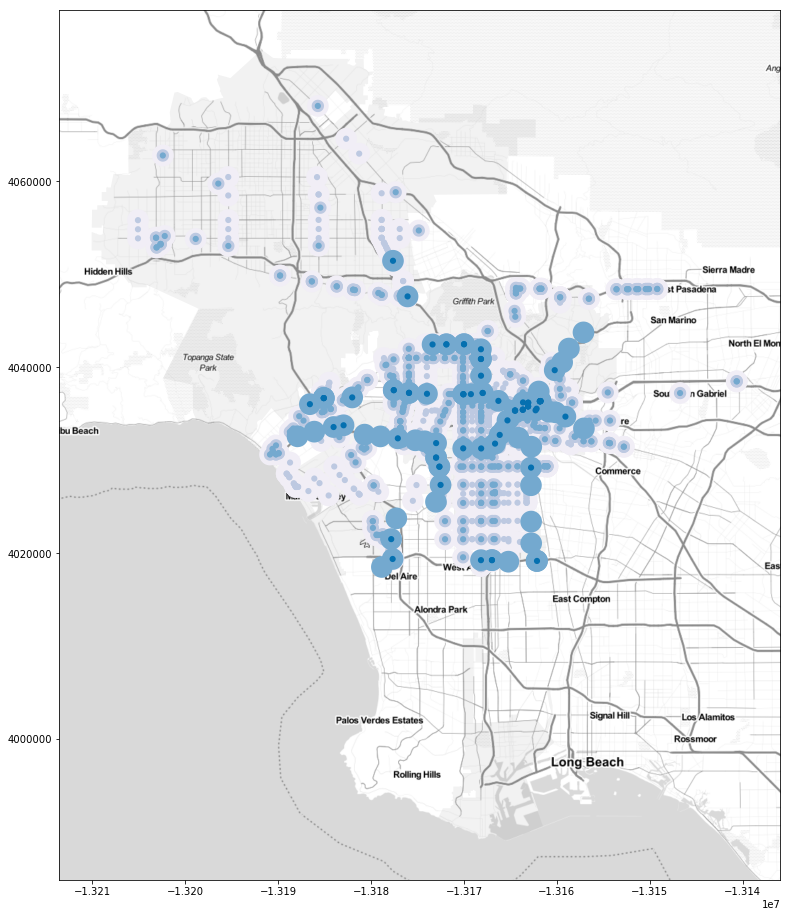

In [12]:
toc_tiers = pandas.concat(
    [
        toc_bus_intersection_tiers,
        toc_metrolink_tiers,
        toc_metro_rail_tiers,
    ],
    axis=0,
    sort=False
)
fig = plot_toc_tiers(toc_tiers)
fig.show()

## Assigning entitlements to conditions

In [13]:
toc_eligible_parcels_with_entitlements = geopandas.read_file(
    "s3://city-planning-entitlements/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
)

In [14]:
parcels = toc_eligible_parcels_with_entitlements.to_crs(epsg=4326)

join = lambda gdf, tier: toc.join_with_toc_tiers(
    gdf,
    toc_bus_intersection_tiers,
    toc_metrolink_tiers,
    toc_metro_rail_tiers,
    tier,
)
        
tier_1 = join(parcels[(parcels.TOC_Tier == 1) & (parcels.num_TOC > 0)], 1)
tier_2 = join(parcels[(parcels.TOC_Tier == 2) & (parcels.num_TOC > 0)], 2)
tier_3 = join(parcels[(parcels.TOC_Tier == 3) & (parcels.num_TOC > 0)], 3)
tier_4 = join(parcels[(parcels.TOC_Tier == 4) & (parcels.num_TOC > 0)], 4)

In [15]:
def summarize(tier, header):
    display(Markdown(header))
    metro_rail_summary = (
        tier.groupby(["station"])
        .size()
        .sort_values(ascending=False)
        .to_frame("Entitlements")
    )
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
    metrolink_summary = (
        tier.groupby("name")
        .size()
        .sort_values(ascending=False)
        .to_frame("Entitlements")
    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("Station")
    )
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
    
    a = tier.groupby("route_name_a").size().to_frame("Entitlements")
    b = tier.groupby("route_name_b").size().to_frame("Entitlements")
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values("Entitlements", ascending=False).head(60))

In [16]:
# TODO: Figure out a better deduplicating strategy.
summarize(tier_1.drop_duplicates(subset=["AIN"]), "## Tier 1 Statistics")
summarize(tier_2.drop_duplicates(subset=["AIN"]), "## Tier 2 Statistics")
summarize(tier_3.drop_duplicates(subset=["AIN"]), "## Tier 3 Statistics")
summarize(tier_4.drop_duplicates(subset=["AIN"]), "## Tier 4 Statistics")

## Tier 1 Statistics

#### Metrolink

,Entitlements
Station,
Van Nuys Metrolink Station,4
Sun Valley Metrolink Station,1


#### Bus Lines

,Entitlements
Bus Route,
10/48,38
164,33
233,28
33,25
212/312,22
204,21
R12,19
224,18
115,14


## Tier 2 Statistics

#### Bus Lines

,Entitlements
Bus Route,
10/48,30
206,26
33,19
754,18
704,17
200,16
4,15
757,13
745,13


## Tier 3 Statistics

#### Metro Rail

,Entitlements
station,
Westlake / MacArthur Park Station,36
Wilshire / Vermont Station,27
Wilshire / Normandie Station,22
Hollywood / Vine Station,21
North Hollywood Station,21
Vermont / Santa Monica Station,18
Soto Station,17
Vermont / Beverly Station,15
Vermont / Sunset Station,14


#### Bus Lines

,Entitlements
Bus Route,
757,41
780,35
754,33
217,28
207,25
10/48,25
704,24
705,19
33,19


## Tier 4 Statistics

#### Metro Rail

,Entitlements
station,
Vermont / Beverly Station,9
Vermont / Sunset Station,8
Wilshire/La Brea,6
Crenshaw/Slauson,6
Vermont / Santa Monica Station,4
Hollywood / Highland Station,3
Expo / Vermont Station,3
Wilshire / Western Station,2
Wilshire / Normandie Station,2
